# Final Project
#### University of Vermont, CS295 Data Privacy
***
#### Authors: Dave Landay, Samson Durst                   
***
## Introduction
***
TODO:
* Define what Edge-DP is and how it is achieved
    * Two Graphs G and G' are neighbors if they differ by one edge 
* Define what Node-DP is and how it is achieved
    * Two graphs G and G' are neighbors if one can be obtained from the other by deleting a node and its adjacent edges. (i.e: differ by one node and sum total of edges connecting that node to other nodes in the network)
* Describe the issues with releasing certain graph metrics (i.e: releasing the number of edges doesn't satisfy node-DP)

In [380]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import count, product
import seaborn as sns
from copy import deepcopy
import sys
sys.path.append("..")

#Import stuff from dpnet package here ...
from dpnet import load_mtx, mechanisms, tools

# Load Networks (networkx actually includes the karate club network):
#karate = load_mtx.load_mtx('../networks/karate/karate.mtx', create_using=None)
karate = nx.karate_club_graph()
youtube= load_mtx.load_mtx('../networks/soc-youtube/soc-youtube.mtx', create_using=None)

def addCapacity(G):
    edge_caps = {edge: sum([G.degree(edge[1]), G.degree(edge[1])]) for edge in G.edges()}
    for edge in G.edges():
        G.add_edge(edge[0], edge[1], capacity=edge_caps[edge])
        
def maxFlow(G,D):
    above_D = [n for n in G.nodes() if G.degree(n) >= D]
    edges2check = [(i,j) for i,j in product(above_D, above_D) if i != j]
    return max([nx.maximum_flow(G,i,j)[0] for i,j in G.edges()])

addCapacity(karate)
addCapacity(youtube)

#### Display an example network (Zachary's Karate club):

{(0, 1): 18, (0, 2): 20, (0, 3): 12, (0, 4): 6, (0, 5): 8, (0, 6): 8, (0, 7): 8, (0, 8): 10, (0, 10): 6, (0, 11): 2, (0, 12): 4, (0, 13): 10, (0, 17): 4, (0, 19): 6, (0, 21): 4, (0, 31): 12, (1, 2): 20, (1, 3): 12, (1, 7): 8, (1, 13): 10, (1, 17): 4, (1, 19): 6, (1, 21): 4, (1, 30): 8, (2, 3): 12, (2, 7): 8, (2, 8): 10, (2, 9): 4, (2, 13): 10, (2, 27): 8, (2, 28): 6, (2, 32): 24, (3, 7): 8, (3, 12): 4, (3, 13): 10, (4, 6): 8, (4, 10): 6, (5, 6): 8, (5, 10): 6, (5, 16): 4, (6, 16): 4, (8, 30): 8, (8, 32): 24, (8, 33): 34, (9, 33): 34, (13, 33): 34, (14, 32): 24, (14, 33): 34, (15, 32): 24, (15, 33): 34, (18, 32): 24, (18, 33): 34, (19, 33): 34, (20, 32): 24, (20, 33): 34, (22, 32): 24, (22, 33): 34, (23, 25): 6, (23, 27): 8, (23, 29): 8, (23, 32): 24, (23, 33): 34, (24, 25): 6, (24, 27): 8, (24, 31): 12, (25, 31): 12, (26, 29): 8, (26, 33): 34, (27, 33): 34, (28, 31): 12, (28, 33): 34, (29, 32): 24, (29, 33): 34, (30, 32): 24, (30, 33): 34, (31, 32): 24, (31, 33): 34, (32, 33): 34}


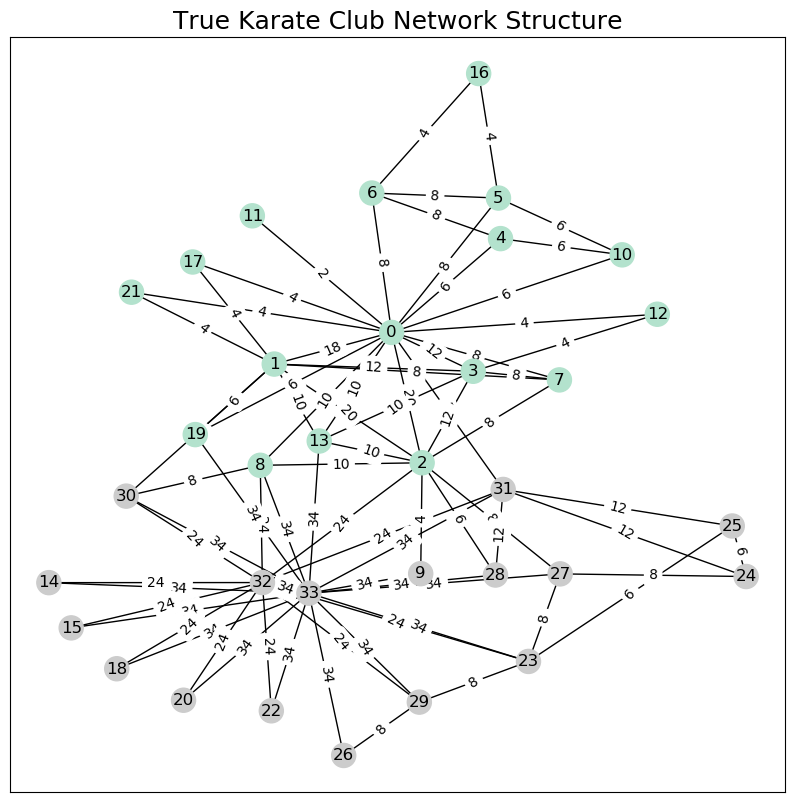

In [391]:
clubs = set(nx.get_node_attributes(karate,'club').values())
mapping = dict(zip(sorted(clubs),count()))
colors = [mapping[karate.nodes[n]['club']] for n in karate.nodes]
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
pos = nx.kamada_kawai_layout(karate, scale=2)
edge_labels = nx.get_edge_attributes(karate,'capacity')
print(edge_labels)
nx.draw_networkx_edge_labels(karate,pos, edge_labels=edge_labels)
ec = nx.draw_networkx_edges(karate, pos)
nc = nx.draw_networkx_nodes(karate, pos, node_color=colors, cmap=plt.cm.Pastel2)
nx.draw_networkx_labels(karate, pos)
plt.title('True Karate Club Network Structure', fontsize=18)
plt.show()

In [145]:
num_nodes = len(karate.nodes)
num_edges = len(karate.edges)
print('number of edges in the karate network: {}\n \
number of nodes in the karate network: {}'.format(num_edges, num_nodes))

number of edges in the karate network: 78
 number of nodes in the karate network: 34


#### Over graphs, simple 1-dimensional queries (like counting the number of nodes) satisfy $(\epsilon, 0)$-node-DP

In [149]:
epsilon = 0.1
sensitivity = 1
noisy_n = mechanisms.laplace_mech(num_nodes, epsilon, sensitivity)
print(noisy_n)

38.565797657416425


#### But releasing the number of edges is not kosher; it does not statisfy $(\epsilon,0)$-node-DP because removing one node could remove an unbounded number of edges

#### Further more, if we look at the true degree distribution, we find that finding an upperbound on the number of edges will have an effect on privacy. If we select an upperbound $k = |V|$, where $V$ is the set of vertices (nodes) in the graph, then we achieve good privacy, but destroy the utility of the released query answer:

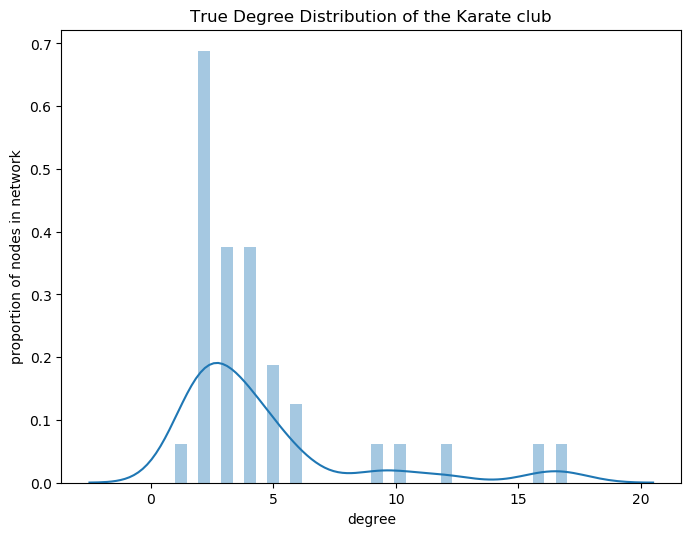

In [5]:
plt.subplots(figsize=(8,6), dpi=100)
bins = int(len(karate.nodes))
sns.distplot([v for k,v in karate.degree()], bins=bins)
plt.xlabel("degree")
plt.ylabel("proportion of nodes in network")
plt.title("True Degree Distribution of the Karate club")
plt.show()

number of edges in the youtube network: 1936749
 number of nodes in the youtube network: 495958


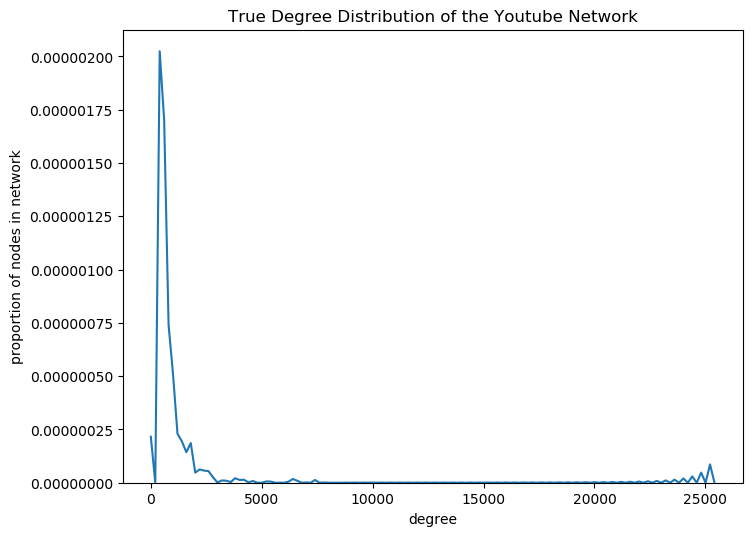

In [6]:
num_nodes = len(youtube.nodes)
num_edges = len(youtube.edges)
print('number of edges in the youtube network: {}\n \
number of nodes in the youtube network: {}'.format(num_edges, num_nodes))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.distplot([v for k,v in youtube.degree()], hist=False, kde=True)
plt.xlabel("degree")
plt.ylabel("proportion of nodes in network")
plt.title("True Degree Distribution of the Youtube Network")
plt.show()

#### Many real-world networks can exhibit power-law degree distributions, or extremely heavy tailed distributions. Hence, the sensitivity of counting queries (specifically range queries) needs to be high. So, we cannot use global sensitivity and expect to maintain privacy. For example, we can use the laplace mechanism to release the number of edges if we find an upper bound on sensitivity first! To do this, we can set an arbitrary upper bound on the number of edges and then remove edges from the graph if a node has more than the proposed bound. Then, we can use the laplace mech scaled to the sensitivity of the upper bound to release the number of edges:

In [7]:
upper = 10
g = tools.clipGraph(karate, upper)
for i in range(10):
    np.random.seed(i)
    print('Noisy edge count that satisfies node-dp: {}'.format(mechanisms.laplace_mech(len(g.edges), epsilon, upper)))

Noisy edge count that satisfies node-dp: 73.27273276031647
Noisy edge count that satisfies node-dp: 44.85308910552921
Noisy edge count that satisfies node-dp: 49.30224525236329
Noisy edge count that satisfies node-dp: 73.71352063225345
Noisy edge count that satisfies node-dp: 334.90051585381184
Noisy edge count that satisfies node-dp: -18.196147788006655
Noisy edge count that satisfies node-dp: 217.04731214107503
Noisy edge count that satisfies node-dp: -124.98265241723666
Noisy edge count that satisfies node-dp: 200.38078652266293
Noisy edge count that satisfies node-dp: -324.52905888166185


In [8]:
upper = 20000
yt = tools.clipGraph(youtube, upper)
noisy_counts = []
for i in range(10):
    np.random.seed(i)
    noisy_counts.append(mechanisms.laplace_mech(len(yt.edges), epsilon, upper))

print('Noisy edge count that satisfies node-dp: {}'.format(np.mean(noisy_counts)))

Noisy edge count that satisfies node-dp: 1910492.4686362215


#### Several of the queries return a decent estimate of the true number of edges. But, clearly for small networks with heavy-tail degree distribution, we cannot use global sensitivity because we risk setting it too high to release a meaningful result. We need to select a good upperbound D that balances two conflicting goals: keeping the sensitivity low and retaining as large a fraction of the graph as possible. We can use the flow-graph Lipschitz extensions defined in https://cs-people.bu.edu/sofya/pubs/nodeprivacy-TCC.pdf (Sec. 4.2). This improves the accuracy of the noise released for edge counts on smaller networks using global sensitivity. 

In [9]:
np.random.seed()

In [449]:
def node_privacy(epsilon, capacity, n, G):
    e1_hat = mechanisms.laplace_mech(len(G.edges), epsilon, 2*n)
    tao = (n*np.log(n))/epsilon
    if e1_hat >= 3*tao:
        return e1_hat
    else:
        total_flow = maxFlow(G,capacity)
        #total_flow = max([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])
        return mechanisms.laplace_mech(total_flow/4, epsilon, 2*capacity)

In [450]:
#node_privacy(3, 25000, len(youtube.nodes), youtube)

In [451]:
for i in range(50):
    print(node_privacy(2, 15, len(karate.nodes), karate))

70.50987486814445
91.20487629845846
69.00790625267443
76.30257520307111
72.01290507874094
66.90332801855338
42.14368385100851
68.79777181931094
75.16126002471097
59.29742951152928
104.25909922750213
79.33295330680531
89.22819705846592
54.39023548147928
76.89241079846313
58.82206471999304
72.7592508861326
80.06090133247805
30.318801405294842
76.23706514969457
64.10979714949853
76.71434203028814
77.97949867109546
62.100187206378735
69.22786587666698
116.57002645771564
78.06925903029665
43.63559893940605
65.20245901072583
100.91649548677496
65.50707792423509
50.474562090848046
54.3464922359905
64.10421446043017
80.81774596850549
81.66548570924223
145.33334248224338
80.83979117321299
96.32372178206975
89.53969144114919
77.96158958518461
52.06301269904378
43.183335429631086
77.31245808687571
71.87290603665576
38.74263904680396
75.04164658575068
85.41796151949946
60.55171339200756
93.68891921168219


#### We can see just how much better the Lipschitz extension is than releasing based on a global sensitivity:

In [460]:
D = 15
epsilon1 = 1
epsilon2 = 4
karate_np_trials_1 = []
karate_global_trials_1 = []
karate_np_trials_2 = []
karate_global_trials_2 = []
#youtube_np_trials = []
for i in range(50):
    np.random.seed(i)
    karate_np_trials_1.append(node_privacy(epsilon1, D, len(karate.nodes), karate))
    karate_global_trials_1.append(mechanisms.laplace_mech(len(g.edges), epsilon1, D))
    karate_np_trials_2.append(node_privacy(epsilon2, D, len(karate.nodes), karate))
    karate_global_trials_2.append(mechanisms.laplace_mech(len(g.edges), epsilon2, D))
    #youtube_np_trials.append(node_privacy(epsilon, 495900, len(youtube.nodes), youtube))

In [458]:
# upper = 20000
# youtube_global_trials = []
# for i in range(50):
#     np.random.seed(i)
#     youtube_global_trials.append(mechanisms.laplace_mech(len(yt.edges), epsilon, upper))

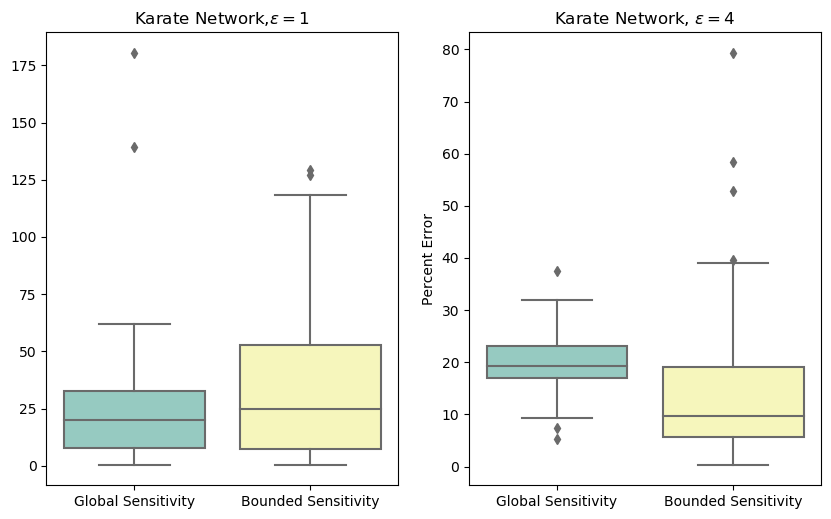

In [462]:
err_knp_1 = np.array([tools.pct_error(i, 78) for i in karate_np_trials_1])
err_kgl_1 = np.array([tools.pct_error(i, 78) for i in karate_global_trials_1])
err_knp_2 = np.array([tools.pct_error(i, 78) for i in karate_np_trials_2])
err_kgl_2 = np.array([tools.pct_error(i, 78) for i in karate_global_trials_2])
#err_ynp = np.array([tools.pct_error(i, 1936749) for i in youtube_np_trials])
#err_ygl = np.array([tools.pct_error(i, 1936749) for i in youtube_global_trials])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), dpi=100, sharex=True)
#fig, ax1 = plt.subplots(figsize=(8,6), dpi = 100)
labels = ['Global Sensitivity', 'Bounded Sensitivity']
sns.boxplot(data=[err_kgl_1, err_knp_1], palette="Set3", ax=ax1)
sns.boxplot(data=[err_kgl_2, err_knp_2], palette="Set3", ax=ax2)

ax1.set_title(r'Karate Network,$\epsilon=$'+str(epsilon1))
ax2.set_title(r'Karate Network, $\epsilon=$'+str(epsilon2))
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)
plt.ylabel('Percent Error')
plt.show()